In [3]:
# This notebook demonstrates fitting a PS by bspline

In [8]:
%pylab inline
import jax_cosmo as jc
import jax.numpy as np
import jax

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
cosmo = jc.Planck15()

In [92]:
k = np.logspace(-2.5,0.25,512)
pk = jc.power.linear_matter_power(cosmo,k)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.num

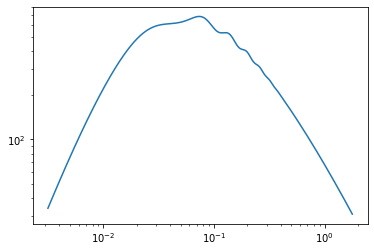

In [144]:
loglog(k,k*pk)

In [112]:
# Ok, so the curve we want to fit is
x = np.linspace(0,1,512)
y = np.log10(k*pk)
y = y - y.min()

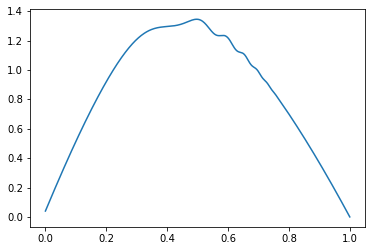

In [113]:
plot(x,y)

In [100]:
from functools import partial

class Bspline():
    """Numpy implementation of Cox - de Boor algorithm in 1D.
    From here: https://github.com/johntfoster/bspline/blob/master/bspline/bspline.py
    """
    def __init__(self, knot_vector, order):
        """Create a Bspline object.
        Parameters:
            knot_vector: Python list or rank-1 Numpy array containing knot vector
                         entries
            order: Order of interpolation, e.g. 0 -> piecewise constant between
                   knots, 1 -> piecewise linear between knots, etc.
        Returns:
            Bspline object, callable to evaluate basis functions at given
            values of `x` inside the knot span.
        """
        kv = np.atleast_1d(knot_vector)
        if kv.ndim > 1:
            raise ValueError("knot_vector must be Python list or rank-1 array, but got rank = %d" % (kv.ndim))
        self.knot_vector = kv

        order = int(order)
        if order < 0:
            raise ValueError("order must be integer >= 0, but got %d" % (order))

        self.p = order

    def __basis0(self, xi):
        """Order zero basis (for internal use)."""
        return np.where(np.all([self.knot_vector[:-1] <=  xi,
                                xi < self.knot_vector[1:]],axis=0), 1.0, 0.0)

    def __basis(self, xi, p, compute_derivatives=False):
        """Recursive Cox - de Boor function (for internal use).
        Compute basis functions and optionally their first derivatives.
        """

        if p == 0:
            return self.__basis0(xi)
        else:
            basis_p_minus_1 = self.__basis(xi, p - 1)

        first_term_numerator = xi - self.knot_vector[:-p]
        first_term_denominator = self.knot_vector[p:] - self.knot_vector[:-p]

        second_term_numerator = self.knot_vector[(p + 1):] - xi
        second_term_denominator = (self.knot_vector[(p + 1):] -
                                   self.knot_vector[1:-p])


        #Change numerator in last recursion if derivatives are desired
        if compute_derivatives and p == self.p:

            first_term_numerator = p
            second_term_numerator = -p

        #Disable divide by zero error because we check for it
        
        first_term = np.where(first_term_denominator != 0.0,
                              (first_term_numerator /
                               first_term_denominator), 0.0)
        second_term = np.where(second_term_denominator != 0.0,
                               (second_term_numerator /
                                second_term_denominator), 0.0)

        return  (first_term[:-1] * basis_p_minus_1[:-1] +
                 second_term * basis_p_minus_1[1:])
    
    def __call__(self, xi):
        """Convenience function to make the object callable.  Also 'memoized' for speed."""
        @jax.vmap
        def fn(x):
            return self.__basis(x, self.p, compute_derivatives=False)
        return fn(xi)
    
    
    def d(self, xi):
        """Convenience function to compute first derivative of basis functions. 'Memoized' for speed."""
        
        @jax.vmap
        def fn(x):
            return self.__basis(x, self.p, compute_derivatives=True)
        
        return fn(xi)

In [101]:
p = 3              # order of spline (as-is; 3 = cubic)
nknots = 32        # number of knots to generate (here endpoints count only once)

In [102]:
knots = np.linspace(0,1,nknots)  # create a knot vector without endpoint repeats

In [103]:
B = Bspline(knots, p)           # create spline basis of order p on knots k

In [104]:
# This is a vector of 
w = np.concatenate([np.zeros(0), np.ones(28), np.zeros(0)])

In [105]:
def eval_spline(t):
    return B(t).dot(w)

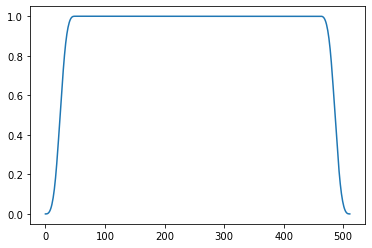

In [106]:
plot(eval_spline(x))

In [107]:
import flax
from flax import nn, optim

class emulator(nn.Module):
    def apply(self, x, 
             w_init=jax.nn.initializers.ones,
             k_init=jax.nn.initializers.ones):
        
        # Get parameters of the spline
        w = self.param('w', (28,), w_init)
        k = self.param('k', (32,),k_init)
        
        # make sure  the knots sum to 1 and are in the interval 0,1
        k = np.cumsum(nn.activation.softmax(k))
        
        B = Bspline(k, order=3)
        return B(x).dot(w)

In [108]:
_, initial_params = emulator.init_by_shape(jax.random.PRNGKey(0),
                                           [((512,), np.float32)])
model = flax.nn.Model(emulator, initial_params)

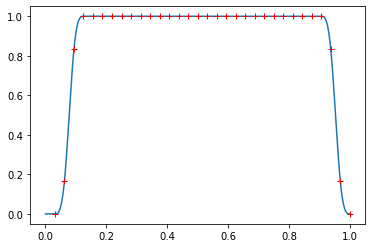

In [109]:
plot(x, model(x))
tx = np.cumsum(nn.activation.softmax(initial_params['k']))
plot(tx, model(tx),'r+')

In [114]:
# For the purpose of this exercise I can also window the PS
from scipy.signal.windows import tukey
w = tukey(512, 0.1)
y = y *w 

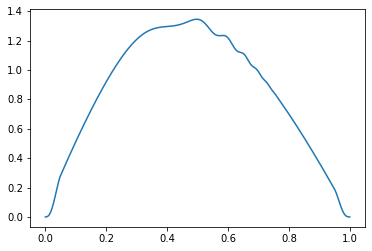

In [115]:
plot(x,y)


In [117]:
@jax.jit
def train_step(optimizer):
  def loss_fn(model):
    pred_y = model(x)
    loss = np.sum((pred_y - y)**2) 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer,l 

In [118]:
# We also need an optimizer
optimizer = flax.optim.Momentum(
      learning_rate=0.001, beta=0.9).create(model)

In [119]:
losses = []

In [129]:
for i in range(1000):
    optimizer, l = train_step(optimizer)
    losses.append(l)
    if i%100 ==0:
        print(l)

0.0053638853
0.005142702
0.0049480987
0.0047758287
0.004622425
0.0044851755
0.0043619135
0.004250391
0.004149352
0.0040572905


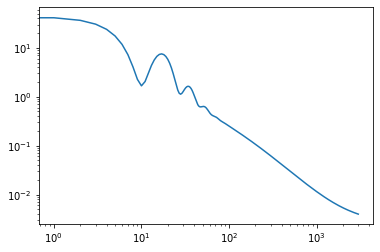

In [130]:
loglog(losses)

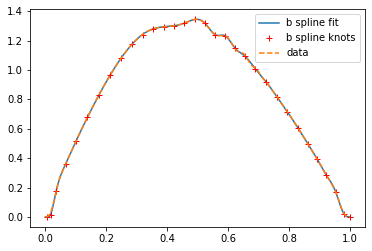

In [131]:
plot(x, optimizer.target(x), label='b spline fit')
tx = np.cumsum(nn.activation.softmax(optimizer.target.params['k']))
plot(tx, optimizer.target(tx),'r+', label='b spline knots')
plot(x,y,'--', label='data')
legend()

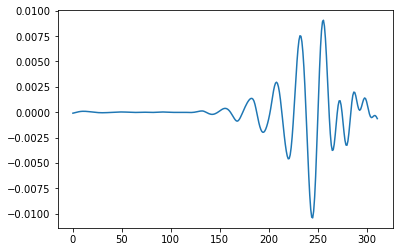

In [136]:
plot(((y-optimizer.target(x))/y)[100:-100])

(0.0, 0.6)

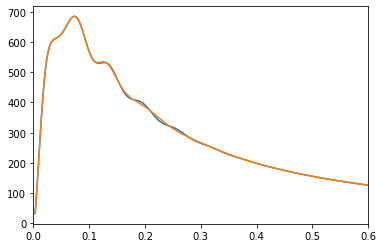

In [142]:
plot(k,k*pk)
plot(k,10**(optimizer.target(x) + np.log10(k*pk).min()))
xlim(0,0.6)